In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-09 14:21:48.750012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

### Model Results for (train white, test black / asian)

In [5]:
# Prepare Model Data --> [takes 2 min.]
pca = PCA(n_components=25) 
prognosis_names = encoded_df.label.unique()

def get_x_y(df): 
    x = np.array([pca.fit_transform(np.transpose(data)) for data in df.sample_data.values]) # shrink to 26 values
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_test_white, y_test_white = get_x_y(test_black_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Assuming your input data is stored in a variable named 'x_input'
# x_input.shape should be (602, 26, 25)
x_input = x_train

# Assuming your one-hot encoded labels are stored in a variable named 'y_output'
# y_output.shape should be (602, 23)
y_output = y_train

# Define the Transformer model using Keras
def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    transformer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=25)(inputs, inputs)
    transformer = GlobalAveragePooling1D()(transformer)
    outputs = Dense(num_classes, activation='softmax')(transformer)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
input_shape = (26, 25)
num_classes = 23  # Assuming 23 classes
transformer_model = build_transformer_model(input_shape, num_classes)

# Compile the model
transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss=CategoricalCrossentropy(),
                          metrics=['accuracy'])

# Train the model
history = transformer_model.fit(x_input, y_output, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
16/16 [==============================] - 2s 25ms/step - loss: 7.1404 - accuracy: 0.3035 - val_loss: 1.8042 - val_accuracy: 0.6860
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 1.4687 - accuracy: 0.5031 - val_loss: 1.5055 - val_accuracy: 0.6860
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 1.2974 - accuracy: 0.6445 - val_loss: 1.3324 - val_accuracy: 0.6860
Epoch 4/10
16/16 [==============================] - 0s 15ms/step - loss: 1.1336 - accuracy: 0.6486 - val_loss: 1.3128 - val_accuracy: 0.6860
Epoch 5/10
16/16 [==============================] - 0s 9ms/step - loss: 1.0975 - accuracy: 0.6549 - val_loss: 1.2418 - val_accuracy: 0.6860
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 1.0654 - accuracy: 0.6632 - val_loss: 1.2646 - val_accuracy: 0.6777
Epoch 7/10
16/16 [==============================] - 0s 8ms/step - loss: 1.0861 - accuracy: 0.6632 - val_loss: 1.2483 - val_accuracy: 0.6777
Epoch 8/10
16/16 [

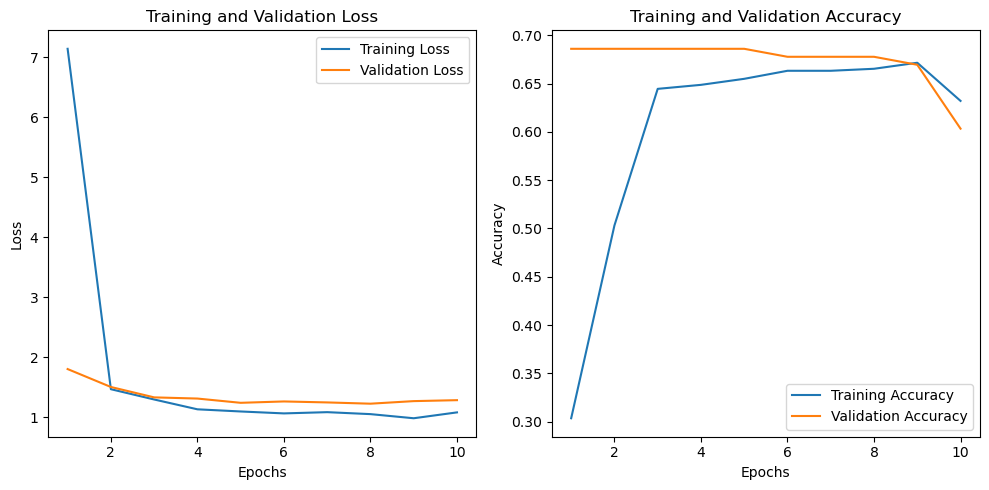

In [15]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Check Test Performance - White Patients
evaluation = transformer_model.evaluate(x_test_white, y_test_white)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on White Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 5ms/step - loss: 1.2427 - accuracy: 0.6154
Performance on White Patients
----------------------------------
Loss on test data: 1.2426713705062866
Accuracy on test data: 0.6153846383094788


In [18]:
# Check Test Performance - Black & AA Patients
evaluation = transformer_model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 7ms/step - loss: 1.2427 - accuracy: 0.6154
Performance on Black Patients
----------------------------------
Loss on test data: 1.2426713705062866
Accuracy on test data: 0.6153846383094788


In [19]:
# Check Test Performance - Asian Patients
evaluation = transformer_model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 39ms/step - loss: 0.7329 - accuracy: 0.9286
Performance on Asian Patients
----------------------------------
Loss on test data: 0.7329235076904297
Accuracy on test data: 0.9285714030265808
